In [1]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [2]:
sem_segm_img_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/2023_RVV_1_mask_255.jpg"
mapbox_imgs_dir_path = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_images_for_frame_255_RVV1"
heli_lat = 50.767451666666666
heli_lon = 3.532935
# 2 intersections so 2 solutions possible
intersec_lat1 = 50.7684072
intersec_lon1 = 3.5304704
intersec_lat2 = 50.7688945
intersec_lon2 = 3.5296422
altitude = 172.57

In [3]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [4]:
def calculate_bearing(lat1, long1, lat2, long2) : 
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    d_long = long2 - long1

    y = math.sin(d_long) * math.cos(lat2)
    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_long)

    brng = math.atan2(y, x)

    brng = math.degrees(brng)
    brng = (brng + 360) % 360
    # brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise
    return brng

In [5]:
def haversine(lat1, lon1, lat2, lon2) : 
    R = 6371
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c * 1000
    return d

In [6]:
# calculate pitch/tilt
def calculate_pitch(heli_lat, heli_lon, intersec_lat, intersec_lon, alt) : 
    dist = haversine(heli_lat, heli_lon, intersec_lat, intersec_lon)

    # result = heli_df[(heli_df['lat'] == heli_lat) & (heli_df['lng'] == heli_lon)]
    # if not result.empty:
    #    altitude = result.iloc[0]['alt']

    print(f"Distance: {dist}")
    print(f"Altitude: {alt}")

    alpha_radian = math.atan2(alt, dist)
    alpha_degrees = alpha_radian * (180.0 / math.pi)
    pitch = 90 - alpha_degrees
    return pitch 

In [7]:
def get_mapbox_intersection_image(lat, lon, bearing, tilt) : 
    if tilt > 60 :
        tilt = 60
    zoom = 18
    width = 512
    height = 512
    access_token = "pk.eyJ1Ijoic2VubmVsb29idXljayIsImEiOiJjbG1zeDVreHowZmw5Mm1xY2lxeTFtYTB2In0.ymj-xZAfeeivbksi1PJttw" 
    styles_url = "mapbox://styles/senneloobuyck/cllcojw8d00wy01pb6rqcdmm5"

    style_code = styles_url.split('/')[-1]

    url = f"https://api.mapbox.com/styles/v1/senneloobuyck/{style_code}/static/{str(lon)},{str(lat)},{str(zoom)},{str(bearing)},{str(tilt)}/{str(width)}x{str(height)}?access_token={access_token}"

    response = requests.get(url)

    if response.status_code == 200:
        with open(f"{lat}_{lon}.jpg", "wb") as f:
            f.write(response.content)
        print(f"Image saved as {lat}_{lon}.jpg")
    else:
        print("Failed to retrieve image for intersection lat = " + str(lat) + ", lon = " + str(lon))
        print(response.text[:100])

In [8]:
def get_intersection_coordinates(lat, lon) : 
    # some lists and dataframes to store the data
    nodes = []
    intersection_nodes = []
    df_nodes = pd.DataFrame(columns=['id', 'lat', 'lon'])
    df_intersections = pd.DataFrame(columns=['lat', 'lon'])

    overpass_url = "http://overpass-api.de/api/interpreter"


    # first get the ways around the point 
    # .w is a temporary variable that stores the result of the first query
    # node(way_cnt:2-);   // select those nodes that are members of two or more of the given ways
    overpass_query = f"""[out:json];
                        way(around: 300, {lat},{lon})["highway"]->.w;
                        node(way_cnt.w:2-);  
                        out;"""

    response = requests.get(overpass_url, params={'data': overpass_query})

    for item in response.json()['elements']:
        df_intersections.loc[len(df_intersections)] = {'lat': item['lat'], 'lon': item['lon']}


    # print(df_intersections)
    return df_intersections

In [9]:
df_intersections = get_intersection_coordinates(heli_lat, heli_lon)

# read in csv file with heli coordinates
heli_path = "/Users/senneloobuyck/Documents/Thesis_project/01_inputs/csv-files/2023 Ronde van Vlaanderen 1 heli.csv"
heli_df = pd.read_csv(heli_path)
heli_df['lat'] = heli_df.apply(lambda row: float(row['lat']) * 1 if row['NS'] == 'N' else float(row['lat']) * (-1), axis=1)
heli_df['lng'] = heli_df.apply(lambda row: float(row['lng']) * 1 if row['EW'] == 'E' else float(row['lng']) * (-1), axis=1)
heli_df = heli_df[['lat', 'lng', 'alt', 'seconds_from_start']]

for index, row in df_intersections.iterrows() : 
    print(f"Intersection: {row['lat']},{row['lon']}")
    bearing = calculate_bearing(heli_lat, heli_lon, row['lat'], row['lon'])
    print(f"Bearing = {bearing}")
    pitch = calculate_pitch(heli_lat, heli_lon, row['lat'], row['lon'], alt=altitude)
    print(f"Pitch = {pitch}")
    # get_mapbox_intersection_image(row['lat'], row['lon'], bearing, pitch)

Intersection: 50.7684072,3.5304704
Bearing = 301.50947631483973
Distance: 203.30137799178232
Altitude: 172.57
Pitch = 49.67412674770758
Intersection: 50.7653196,3.5320148
Bearing = 195.26895370959184
Distance: 245.74948727870196
Altitude: 172.57
Pitch = 54.922733942845504
Intersection: 50.7688945,3.5296422
Bearing = 304.716115883337
Distance: 281.71707199286163
Altitude: 172.57
Pitch = 58.50982518652806
Intersection: 50.7648515,3.5334546
Bearing = 172.79626760139513
Distance: 291.42557105406456
Altitude: 172.57
Pitch = 59.36776189102956
Intersection: 50.7686638,3.5306849
Bearing = 310.42373248858524
Distance: 207.8626619229089
Altitude: 172.57
Pitch = 50.30014796480231
Intersection: 50.7677603,3.5327413
Bearing = 338.34996574798856
Distance: 36.923241225871806
Altitude: 172.57
Pitch = 12.076965217672424
Intersection: 50.7645454,3.5376782
Bearing = 134.0887351806312
Distance: 464.4504262175182
Altitude: 172.57
Pitch = 69.61707781196316
Intersection: 50.7671091,3.536825
Bearing = 97.9252

In [10]:
def get_skeleton(mask_bgr, contour) : 
    # print("Getting the skeleton and the pruned skeleton")

    mask_gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)

    # draw contour in white on black background
    contour_mask_gray = np.zeros_like(mask_gray)
    cv2.drawContours(contour_mask_gray, [contour], -1, 255, -1)
    contour_mask_bgr = cv2.cvtColor(contour_mask_gray, cv2.COLOR_GRAY2BGR)
    
    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh = threshold_otsu(contour_mask_gray)
    contour_mask_gray = contour_mask_gray > thresh
    
    # 1. Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(contour_mask_gray, method='lee').astype(np.uint8)

    np.set_printoptions(threshold=np.inf)
    # print("Skeleton image values:")
    # print(skeleton_gray)


    # plt.figure(figsize=(20,10))
    # plt.imshow(skeleton_gray, cmap='gray', interpolation='nearest')
    # plt.show()

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)

    return skeleton_bgr
            

In [11]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for x in range(1,len(image)-1):
        for y in range(1,len(image[x])-1):
            # if we have a white pixel
            if image[x][y] == 1:
                neighbours = [image[x-1][y], image[x-1][y-1], image[x][y-1], image[x+1][y-1], image[x+1][y], image[x+1][y+1], image[x][y+1], image[x-1][y+1]]
                if neighbours in validIntersection:
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections


In [12]:
def prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold) : 
    print("Pruning the skeleton")
    pruned_skeleton_contour_bgr = np.zeros_like(skeleton_contour_bgr) 
    bad_contours = []
    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr_help = skeleton_contour_bgr.copy()
        # cv2.circle(pruned_skeleton_contour_bgr_help, (intersection[0], intersection[1]), 1, (0,0,0), -1)
        pruned_skeleton_contour_bgr_help[intersection[1], intersection[0]] = (0,0,0)

        pruned_skeleton_contour_gray_help = cv2.cvtColor(pruned_skeleton_contour_bgr_help, cv2.COLOR_BGR2GRAY)
        contours, hierarchy = cv2.findContours(pruned_skeleton_contour_gray_help, cv2.RETR_EXTERNAL , cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours : 
            if cv2.arcLength(contour, closed=False) > threshold :
                cv2.drawContours(pruned_skeleton_contour_bgr, [contour], contourIdx=-1, color=(255, 255, 255), thickness=1)
            else : 
                bad_contours.append(contour)

    for bad_contour in bad_contours :
        cv2.drawContours(pruned_skeleton_contour_bgr, [bad_contour], contourIdx=-1, color=(0, 0, 0), thickness=1)

    for intersection in skel_intersections : 
        pruned_skeleton_contour_bgr[intersection[1], intersection[0]] = (255,255,255)
    return pruned_skeleton_contour_bgr    

In [13]:
def get_patch_from_intersection(skel_contour_bgr, intersec, patch_size) : 
    # print("Getting patch from intersection")
    skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate the coordinates of the patch boundaries
    x, y = intersec[0], intersec[1]
    x_min, x_max = x - patch_size // 2, x + patch_size // 2 + 1
    y_min, y_max = y - patch_size // 2, y + patch_size // 2 + 1

    # Ensure the coordinates are within the image bounds
    x_min = max(0, x_min)
    x_max = min(skel_contour_gray.shape[1], x_max)
    y_min = max(0, y_min)
    y_max = min(skel_contour_gray.shape[0], y_max)

    # Extract the patch
    patch = skel_contour_gray[y_min:y_max, x_min:x_max]

    # Patch intersection value
    patch_intersection = (patch.shape[0]//2, patch.shape[1]//2)

    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            if patch[patch_intersection[1]+y, patch_intersection[0]+x] == 255 and (x != 0 or y != 0):
                road_neighbour_pixels.append((patch_intersection[0]+x, patch_intersection[1]+y))

    return patch, road_neighbour_pixels

In [14]:
def find_road_pixels(patch, reference_pixel, neighbour_pixels, intersection, visited_pixels=None):
    if visited_pixels is None:
        visited_pixels = set()

    # print("Finding road pixels")
    # print(f"Intersection = {intersection}")
    patch_size = patch.shape[0]
    road_pixels = []

    for x in range(-1, 2):
        for y in range(-1, 2):
            pixel = (reference_pixel[0] + x, reference_pixel[1] + y)

            # Check if the pixel has been visited or is out of bounds
            if pixel[0] < 0 or pixel[0] >= patch_size or pixel[1] < 0 or pixel[1] >= patch_size or pixel in visited_pixels:
                continue

            # Check if the pixel is a road pixel and not the intersection itself
            if patch[pixel[1], pixel[0]] == 255 and (x != 0 or y != 0) and pixel != intersection and pixel not in neighbour_pixels:
                road_pixels.append(pixel)
                visited_pixels.add(pixel)
                # Recursively search from this pixel
                road_pixels += find_road_pixels(patch, pixel, neighbour_pixels, intersection, visited_pixels)
    
    return road_pixels


In [15]:
def get_descriptor(patch, neighbour_pixels) : 
    # For visualisation purposes
    patch_bgr = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
    
    # Find intersection and set value to 0
    intersection = (patch.shape[0]//2, patch.shape[1]//2)
    patch[intersection[0], intersection[1]] = 0

    angles_vector = []
    
    
    
    # if lines is None : 
    #     print("No houghlines found")
    # else :
    #     for i in range(0, len(lines)):
    #         rho = lines[i][0][0]
    #         theta = lines[i][0][1]
    #         a = math.cos(theta)
    #         b = math.sin(theta)
    #         x0 = a * rho
    #         y0 = b * rho
    #         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    #         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    #         cv2.line(patch_bgr, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

    # print("Patch with houghlines")
    # plot_image(patch_bgr)

    for neighbour_pixel in neighbour_pixels :
        road_pixels = find_road_pixels(patch, neighbour_pixel, neighbour_pixels, intersection, None)
        road_pixels.append(neighbour_pixel)
        road_pixels.append(intersection)
        print(f"Road pixels for neighbour pixel {neighbour_pixel} (including intersection): ")
        # print(road_pixels)

        # now append the neighbour pixel AND the intersection pixel to the road pixels 
        # road_pixels.append(intersection)

        # Switch y values because the y axis is inverted
        road_pixels = [(pixel[0], (patch.shape[0]-1) - pixel[1]) for pixel in road_pixels]

        # Adjust the coordinates of road pixels and intersection to be relative to the center
        adjusted_road_pixels = [(pixel[0] - intersection[0], pixel[1] - intersection[1]) for pixel in road_pixels]

        # convert to numpy array
        road_pixels = np.array(adjusted_road_pixels, dtype=np.float32)
        print(f"Road pixels after adjustment (intersection is now origin): ")
        print(road_pixels)


        # For each set of coordinates, compute the best-fit line
        x_values = np.array([coord[0] for coord in road_pixels])
        y_values = np.array([coord[1] for coord in road_pixels])
  

        # Check if all x-values are the same
        all_x_values_same = all(x == x_values[0] for x in x_values)
        if all_x_values_same :
            if neighbour_pixel[1] > intersection[1] :
                angle = 270
            else :
                angle = 90
            angles_vector.append(angle)
            continue

        line = np.polyfit(x_values, y_values, deg=1)
        
        print(f"Line: {line}")

        # Now show the line on the patch
        a = line[0]
        b = line[1]
        y = a * x_values + b
        plt.plot(x_values, y)
        plt.show()

        # The slope of each line gives the direction of the road segment it fits
        angle = np.degrees(np.arctan(a))

        if angle > 0 :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] > intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
        else :
            if (neighbour_pixel[0] == intersection[0] and neighbour_pixel[1] < intersection[1]) or neighbour_pixel[0] < intersection[0] :
                angle = angle + 180
            else : 
                angle = angle + 360

        print(f"Direction is: {angle}")
        angles_vector.append(angle)

        # Calculate the direction vector

        # Fit lines using the points
        # vx, vy, x0, y0 = cv2.fitLine(road_pixels, cv2.DIST_L2, 0, 0.01, 0.01)
        # print(f"vx = {vx}, vy = {vy}, x0 = {x0}, y0 = {y0}")

        # direction_vector = (vx[0], vy[0])

        # # Calculate the angle in radians
        # angle_radians = math.atan2(vy[0], vx[0])

        # # Convert the angle to degrees
        # angle_degrees = math.degrees(angle_radians)

        # print(f"Angle: {angle_degrees} degrees")

        # direction_vectors.append(direction_vector)
    
    # print(f"Direction vectors: {angles_vector}")
    # sort direction_vectors from small to big
    angles_vector_sorted = sorted(angles_vector)
    print(f"Sorted vector of angles: {angles_vector_sorted}")

    descriptor = angles_vector_sorted

    # descriptor = []
    # # define a descriptor based on angles_vector_sorted
    # for i in range(1, len(angles_vector_sorted)): 
    #     angle_ratio = angles_vector_sorted[i] / angles_vector_sorted[0]
    #     descriptor.append(angle_ratio) 
        
    # print(f"Descriptor = {descriptor}")
    
    return descriptor


In [16]:
def find_descriptors_in_segmentation_image(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(mask_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                
                # prune the skeleton to remove small branches
                threshold = 300
                pruned_skeleton_contour_bgr = prune_skeleton(skeleton_contour_bgr, skel_intersections, threshold)
                plot_image(pruned_skeleton_contour_bgr)
                
                # now find the possible intersection, if there is one
                pruned_skel_intersections = get_skeleton_intersection(pruned_skeleton_contour_bgr)

                # further processing
                if pruned_skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    pruned_skeleton_contour_bgr_copy = pruned_skeleton_contour_bgr.copy()
                    for intersection in pruned_skel_intersections :
                        pruned_skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for prune_intersection in pruned_skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(pruned_skeleton_contour_bgr, prune_intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors
    

In [17]:
def find_descriptors_in_segmentation_image_without_pruning(img_path) : 
    print("Finding descriptors in segmentation image")
    
    img_bgr = cv2.imread(img_path)
    print("Segmentation image")
    plot_image(img_bgr)

    closing_bgr = isotropic_closing(img_bgr, radius=30)
    closing_bgr = closing_bgr.astype(np.uint8) * 255
    print("Isotropic closing of segmentation image")
    plot_image(closing_bgr)

    closing_bgr_copy = closing_bgr.copy()
    closing_gray = cv2.cvtColor(closing_bgr, cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(closing_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Number of contours: {len(contours)}")
    cv2.drawContours(closing_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            solidity = contour_area / convex_hull_area

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(closing_bgr_copy, contour)

            plot_image(skeleton_contour_bgr)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")
            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")
                

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(pruned_skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

Finding descriptors in segmentation image
Segmentation image


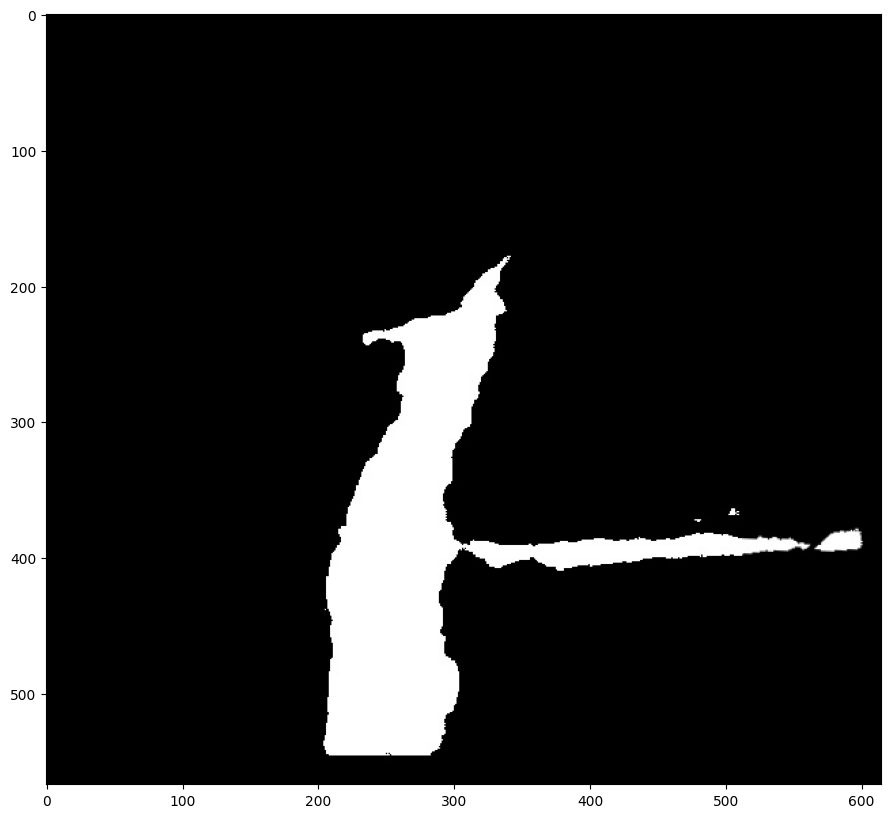

Isotropic closing of segmentation image


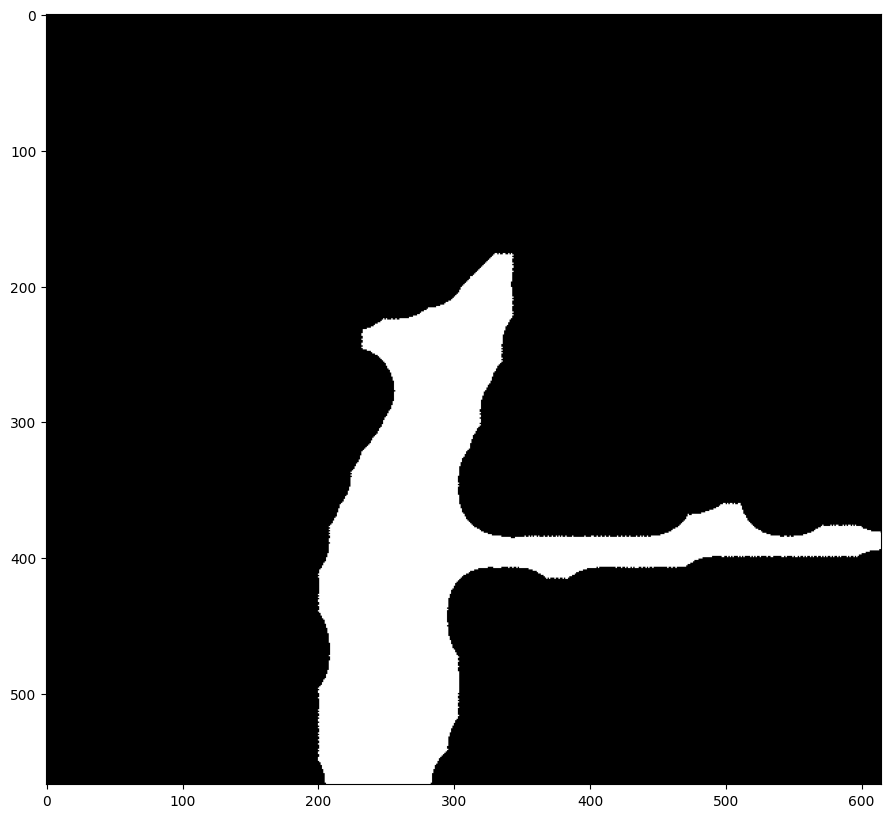

Number of contours: 1
Contour length: 1798.2926244735718
Contour area: 39482.0
Convex hull area: 97220.0


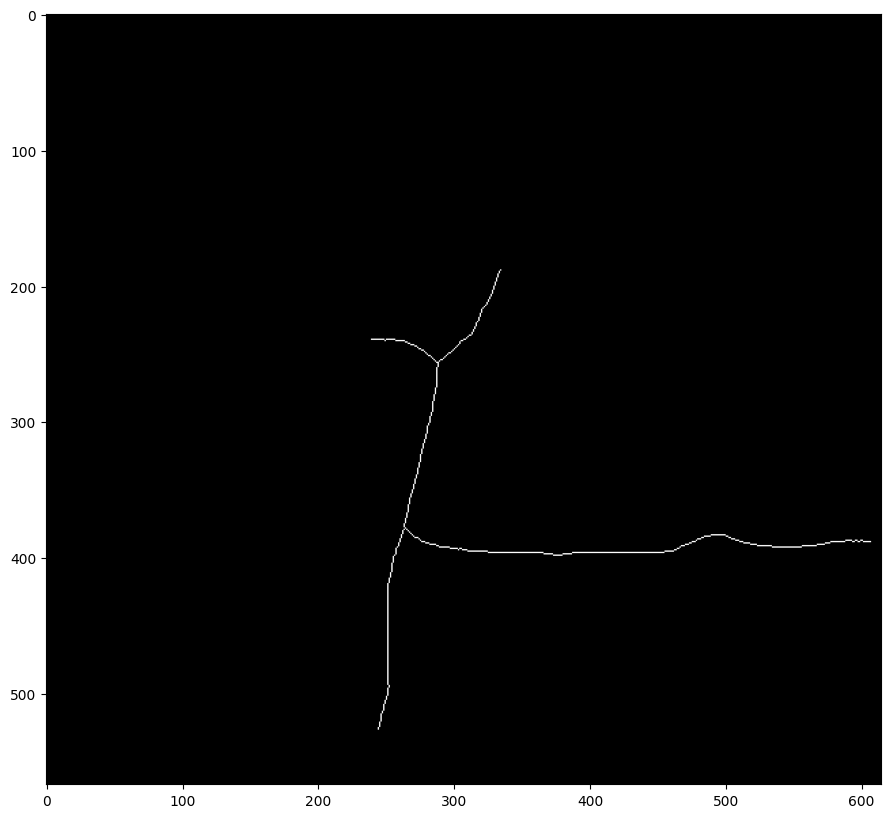

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton
Solidity = 0.4061098539395186 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images
Road neighbour pixels: [(14, 15), (15, 16), (16, 14)]
Number of roads that intersect in this intersection: 3
Patch:


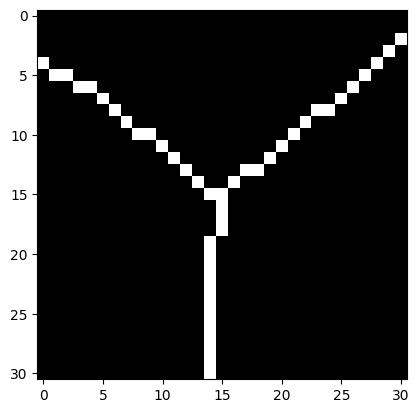

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 255]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0 255   0]
 [255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0 255   0   0]
 [  0 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 255   0   0   0]
 [  0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 255   0   0   0   0]
 [  0   0   0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0  

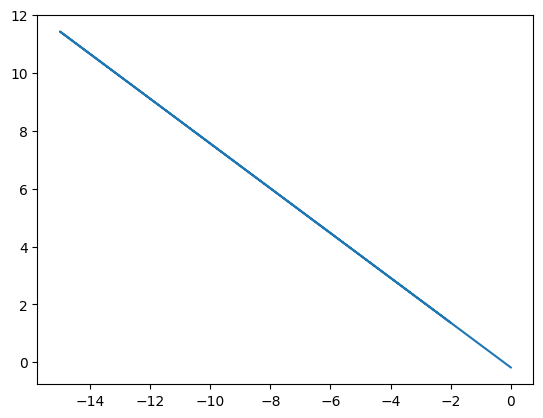

Direction is: 142.27699418746568
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -1.  -6.]
 [ -1.  -7.]
 [ -1.  -8.]
 [ -1.  -9.]
 [ -1. -10.]
 [ -1. -11.]
 [ -1. -12.]
 [ -1. -13.]
 [ -1. -14.]
 [ -1. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 8.  -1.5]


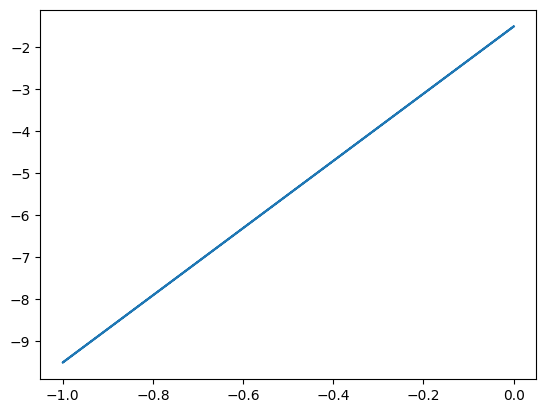

Direction is: 262.8749836510982
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  2.]
 [ 4.  3.]
 [ 5.  4.]
 [ 6.  5.]
 [ 7.  6.]
 [ 8.  7.]
 [ 9.  7.]
 [10.  8.]
 [11.  9.]
 [12. 10.]
 [13. 11.]
 [14. 12.]
 [15. 13.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 0.85  -0.125]


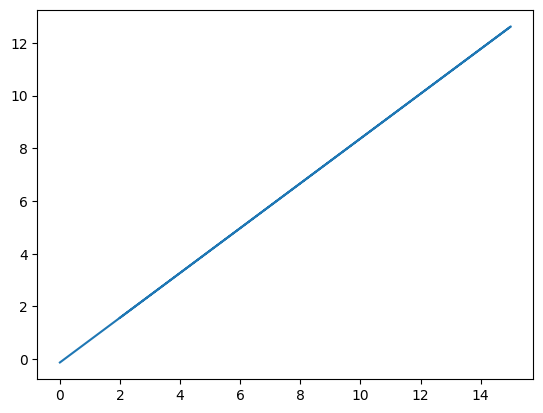

Direction is: 40.36453657309736
Sorted vector of angles: [40.36453657309736, 142.27699418746568, 262.8749836510982]
Road neighbour pixels: [(14, 14), (14, 16), (16, 16)]
Number of roads that intersect in this intersection: 3
Patch:


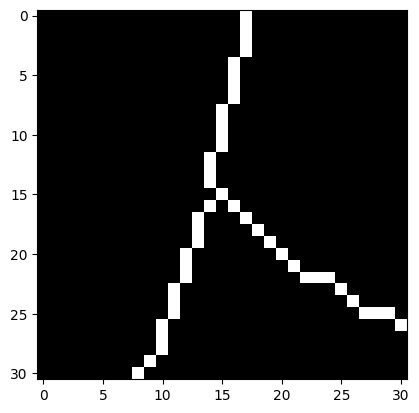

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
    0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0
    0   0   0   0   0  

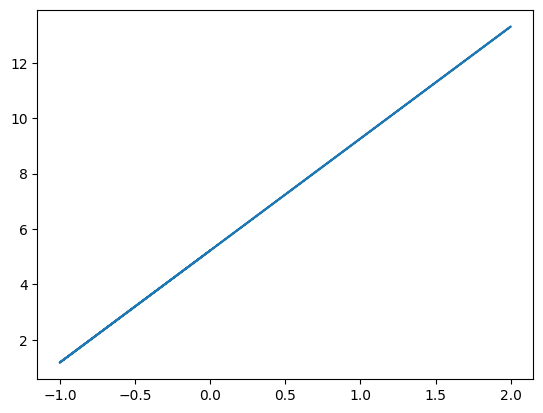

Direction is: 256.1033035169851
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -3.  -5.]
 [ -3.  -6.]
 [ -3.  -7.]
 [ -4.  -8.]
 [ -4.  -9.]
 [ -4. -10.]
 [ -5. -11.]
 [ -5. -12.]
 [ -5. -13.]
 [ -6. -14.]
 [ -7. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [2.5  1.25]


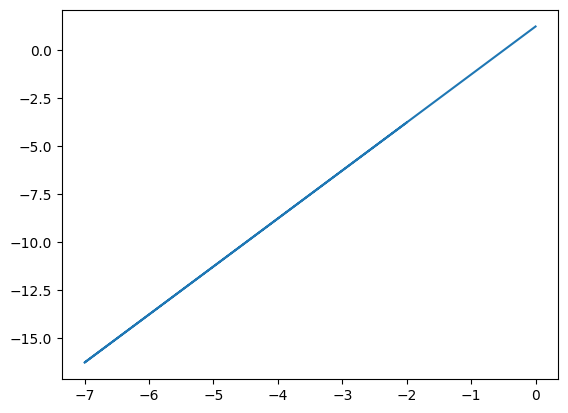

Direction is: 248.19859051364818
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -7.]
 [  9.  -7.]
 [ 10.  -8.]
 [ 11.  -9.]
 [ 12. -10.]
 [ 13. -10.]
 [ 14. -10.]
 [ 15. -11.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.71470588 -0.88970588]


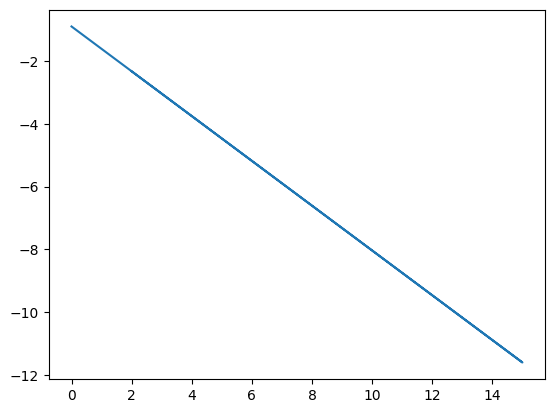

Direction is: 324.4463845785304
Sorted vector of angles: [248.19859051364818, 256.1033035169851, 324.4463845785304]
Array of descriptors: [[40.36453657309736, 142.27699418746568, 262.8749836510982], [248.19859051364818, 256.1033035169851, 324.4463845785304]]


In [18]:
# segm_img_des = find_descriptors_in_segmentation_image(sem_segm_img_path)
segm_img_des = find_descriptors_in_segmentation_image_without_pruning(sem_segm_img_path)
print(f"Array of descriptors: {segm_img_des}")

In [19]:
def find_descriptors_in_mapbox_image(img_path, image_name) : 
    print(f"Finding descriptors in mapbox image {image_name}")
    
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    # print("Cropped mapbox image")
    # plot_image(cropped_img_bgr)

    # print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    # plot_image(thresh_bgr)

    thresh_bgr_copy = thresh_bgr.copy()

    contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(f"Number of contours: {len(contours)}")
    # cv2.drawContours(thresh_bgr_copy, contours, contourIdx=-1, color=(255, 0, 0), thickness=2)

    descriptors = []

    for contour in contours :
        contour_length = cv2.arcLength(contour, closed=True)
        # print(f"Contour length: {contour_length}")
        contour_area = cv2.contourArea(contour)
        # print(f"Contour area: {contour_area}")

        # measure the irregularity of the polygon
        if contour_length != 0 :
            convex_hull = cv2.convexHull(contour)
            convex_hull_area = cv2.contourArea(convex_hull)
            # print(f"Convex hull area: {convex_hull_area}")
            # cv2.polylines(mask_bgr_copy, [convex_hull], isClosed=True, color=(0, 255, 0), thickness=3)
            if convex_hull_area != 0 :
                solidity = contour_area / convex_hull_area
            else :
                solidity = 0

            # get skeleton of the contour
            skeleton_contour_bgr = get_skeleton(thresh_bgr_copy, contour)
            
            # find the intersections in the skeleton
            skel_intersections = get_skeleton_intersection(skeleton_contour_bgr)

            print(f"{len(skel_intersections)} intersections found in the skeleton")

            
            #  make a decision based on the solidity
            if solidity < 0.60 and skel_intersections != [] :
                print(f"Solidity = {solidity} -> this contour can be related to an intersection in the road")

                # further processing
                if skel_intersections == [] : 
                    print("No intersection is found in a possible intersection contour")
                else : 
                    # visualization
                    skeleton_contour_bgr_copy = skeleton_contour_bgr.copy()
                    for intersection in skel_intersections :
                        skeleton_contour_bgr_copy[intersection[1], intersection[0]] = [0, 0, 255]
                    # plot_image(skeleton_contour_bgr_copy)
                    # now try and match intersection with the openstreetmap images
                    print("Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images")
                    for intersection in skel_intersections :
                        patch_size = 31 # needs to be odd number
                        patch, neighbour_road_pixels = get_patch_from_intersection(skeleton_contour_bgr, intersection, patch_size)
                        # print(f"Road neighbour pixels: {neighbour_road_pixels}")
                        # print(f"Number of roads that intersect in this intersection: {len(neighbour_road_pixels)}")
                        # print("Patch:")
                        plt.imshow(patch, cmap='gray')
                        plt.show()
                        # print(patch)
                        descriptor = get_descriptor(patch, neighbour_road_pixels)
                        descriptors.append(descriptor)
            else :
                print(f"Solidity = {solidity} -> no intersection in this contour")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

**************************************************
Mapbox image: 50.7686638_3.5306849.jpg
**************************************************
Finding descriptors in mapbox image 50.7686638_3.5306849.jpg
Getting intersections in skeleton (more than 2 neighbours)
4 intersections found in the skeleton
Solidity = 0.1250583605682652 -> this contour can be related to an intersection in the road
Intersection is found in a possible intersection contour, now try and match it with the openstreetmap images


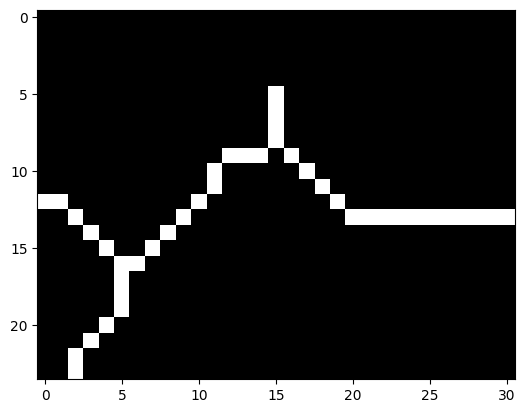

Sorted vector of angles: []


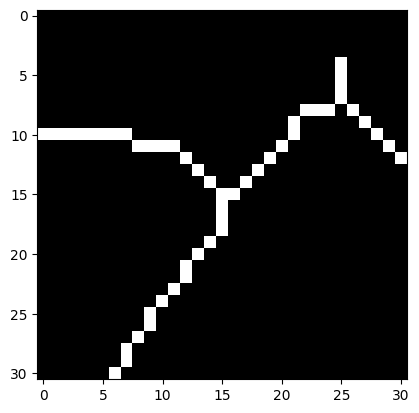

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   4.]
 [ -6.   4.]
 [ -7.   4.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   5.]
 [-11.   5.]
 [-12.   5.]
 [-13.   5.]
 [-14.   5.]
 [-15.   5.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.28529412  1.73529412]


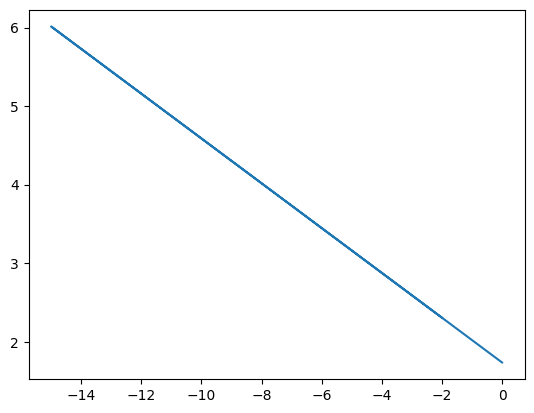

Direction is: 164.07686353055752
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [  0.  -3.]
 [ -1.  -4.]
 [ -2.  -5.]
 [ -3.  -6.]
 [ -3.  -7.]
 [ -4.  -8.]
 [ -5.  -9.]
 [ -6. -10.]
 [ -6. -11.]
 [ -7. -12.]
 [ -8. -13.]
 [ -8. -14.]
 [ -9. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.4699187  -1.80406504]


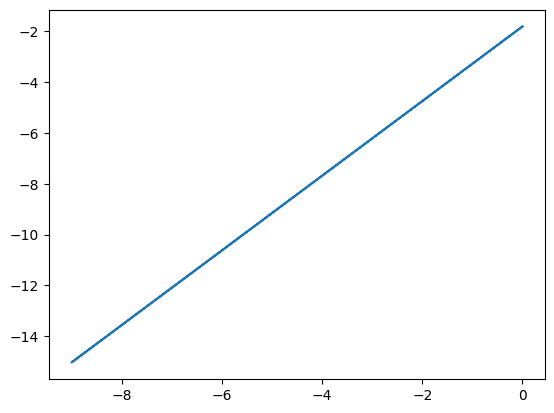

Direction is: 235.77216443992396
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 4.  3.]
 [ 5.  4.]
 [ 6.  5.]
 [ 6.  6.]
 [ 7.  7.]
 [ 8.  7.]
 [ 9.  7.]
 [10.  8.]
 [10.  9.]
 [10. 10.]
 [10. 11.]
 [11.  7.]
 [12.  6.]
 [13.  5.]
 [14.  4.]
 [15.  3.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [0.41759465 1.99276169]


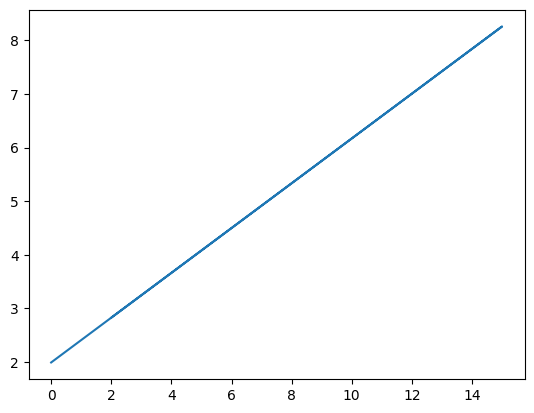

Direction is: 22.66515446474269
Sorted vector of angles: [22.66515446474269, 164.07686353055752, 235.77216443992396]


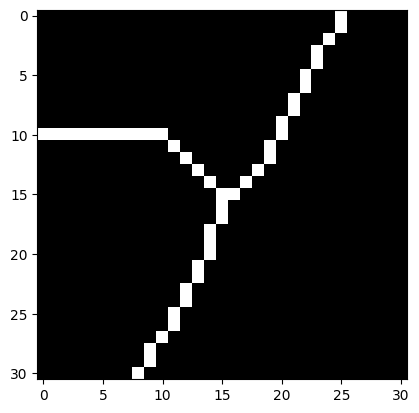

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   5.]
 [ -7.   5.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   5.]
 [-11.   5.]
 [-12.   5.]
 [-13.   5.]
 [-14.   5.]
 [-15.   5.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.27205882  2.02205882]


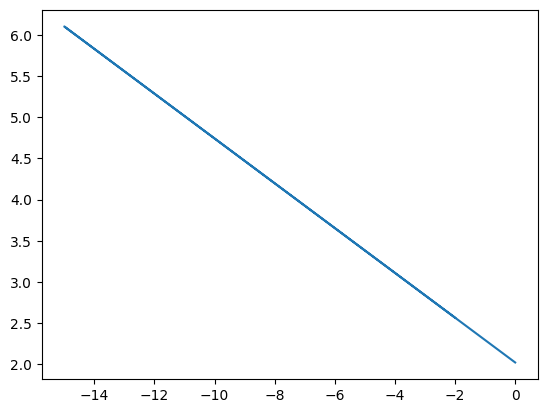

Direction is: 164.7805351688262
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  0.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -3.  -8.]
 [ -3.  -9.]
 [ -4. -10.]
 [ -4. -11.]
 [ -5. -12.]
 [ -6. -13.]
 [ -6. -14.]
 [ -7. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 2.02020202 -1.81818182]


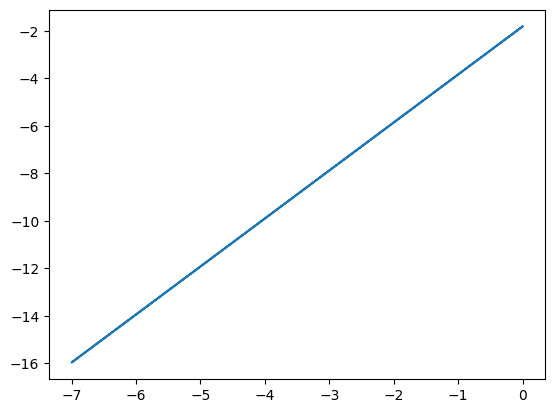

Direction is: 243.66458999611865
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 4.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 5.  6.]
 [ 6.  7.]
 [ 6.  8.]
 [ 7.  9.]
 [ 7. 10.]
 [ 8. 11.]
 [ 8. 12.]
 [ 9. 13.]
 [10. 14.]
 [10. 15.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 1.62653061 -2.03061224]


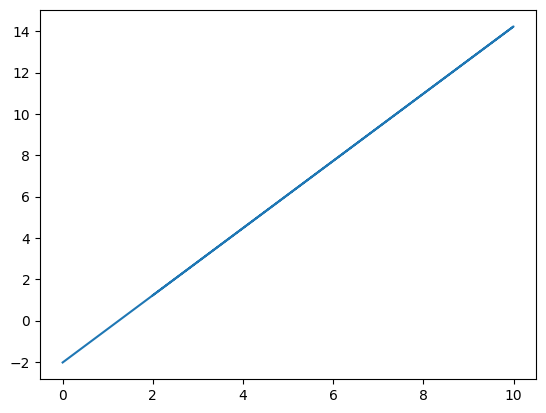

Direction is: 58.416569923546724
Sorted vector of angles: [58.416569923546724, 164.7805351688262, 243.66458999611865]


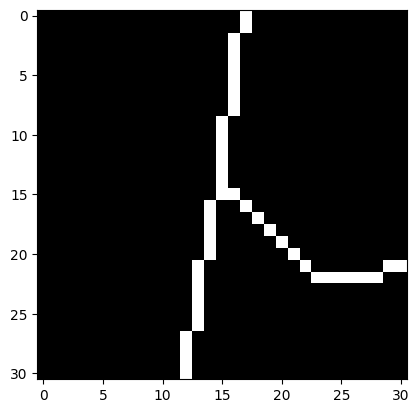

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -2.  -8.]
 [ -2.  -9.]
 [ -2. -10.]
 [ -2. -11.]
 [ -3. -12.]
 [ -3. -13.]
 [ -3. -14.]
 [ -3. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [4.94472362 1.46231156]


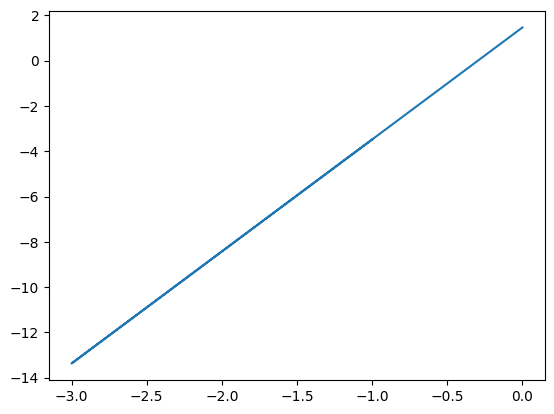

Direction is: 258.56694726722554
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [ 0.  4.]
 [ 0.  5.]
 [ 0.  6.]
 [ 1.  7.]
 [ 1.  8.]
 [ 1.  9.]
 [ 1. 10.]
 [ 1. 11.]
 [ 1. 12.]
 [ 1. 13.]
 [ 2. 14.]
 [ 2. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [6.11764706 3.29411765]


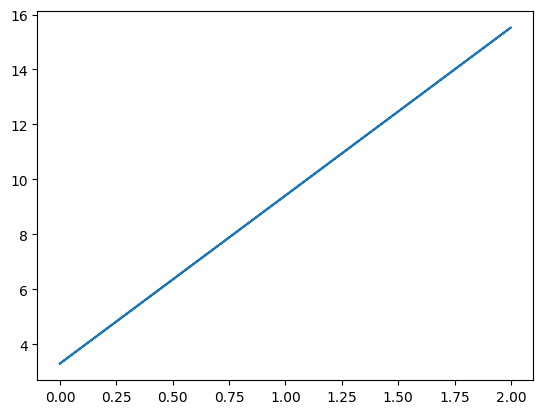

Direction is: 80.71644719473866
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -1.]
 [ 3. -2.]
 [ 4. -3.]
 [ 5. -4.]
 [ 6. -5.]
 [ 7. -6.]
 [ 8. -7.]
 [ 9. -7.]
 [10. -7.]
 [11. -7.]
 [12. -7.]
 [13. -7.]
 [14. -6.]
 [15. -6.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.48382353 -1.05882353]


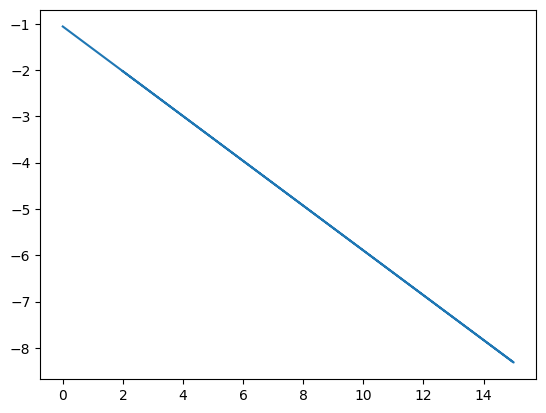

Direction is: 334.1812104390141
Sorted vector of angles: [80.71644719473866, 258.56694726722554, 334.1812104390141]
Descriptors: [[], [22.66515446474269, 164.07686353055752, 235.77216443992396], [58.416569923546724, 164.7805351688262, 243.66458999611865], [80.71644719473866, 258.56694726722554, 334.1812104390141]] for mapbox image 50.7686638_3.5306849.jpg
Number of descriptors: 4
Descriptor of segmentation image:
[40.36453657309736, 142.27699418746568, 262.8749836510982]
Descriptor of mapbox image:
[]
Descriptor of mapbox image:
[22.66515446474269, 164.07686353055752, 235.77216443992396]
x = 40.36453657309736, y = 22.66515446474269
x = 142.27699418746568, y = 164.07686353055752
x = 262.8749836510982, y = 235.77216443992396
Result = 39.026468448823515
Descriptor of mapbox image:
[58.416569923546724, 164.7805351688262, 243.66458999611865]
x = 40.36453657309736, y = 58.416569923546724
x = 142.27699418746568, y = 164.7805351688262
x = 262.8749836510982, y = 243.66458999611865
Result = 34.6

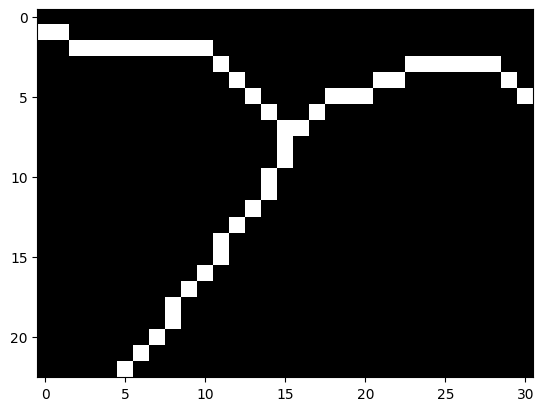

Road pixels for neighbour pixel (10, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2. -10.]
 [ -3. -11.]
 [ -3. -12.]
 [ -4. -13.]
 [ -5. -14.]
 [ -6. -15.]
 [ -1.  -9.]
 [  0.  -8.]]
Line: [ 1.21428571 -7.85714286]


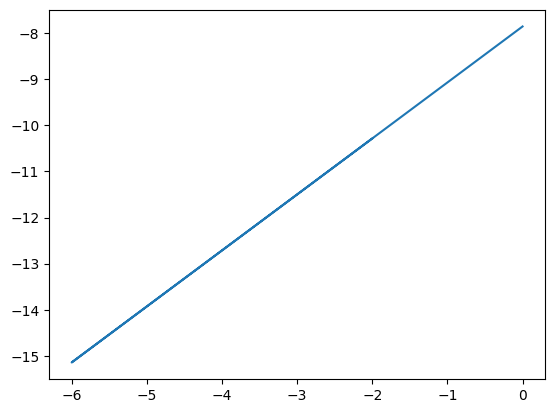

Direction is: 230.52754015165618
Road pixels for neighbour pixel (11, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  1.  -6.]
 [  2.  -5.]
 [  3.  -4.]
 [  3.  -3.]
 [  4.  -2.]
 [  4.  -1.]
 [  4.   0.]
 [  3.   1.]
 [  2.   2.]
 [  1.   3.]
 [  0.   4.]
 [ -1.   5.]
 [ -2.   5.]
 [ -3.   5.]
 [ -4.   5.]
 [ -5.   5.]
 [ -6.   5.]
 [ -7.   5.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   6.]
 [-11.   6.]
 [  5.   0.]
 [  6.   1.]
 [  7.   2.]
 [  8.   2.]
 [  9.   2.]
 [ 10.   3.]
 [ 11.   3.]
 [  0.  -7.]
 [  0.  -8.]]
Line: [-0.28092595  1.573411  ]


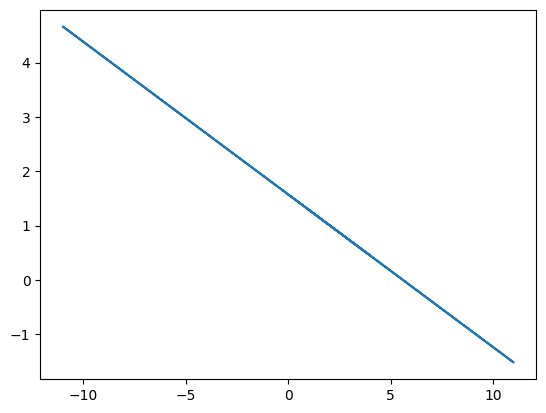

Direction is: 164.30856940209483
Sorted vector of angles: [164.30856940209483, 230.52754015165618]


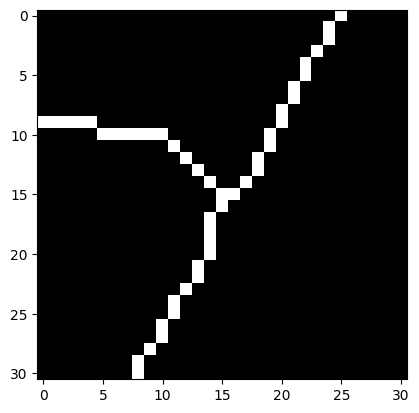

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   5.]
 [ -7.   5.]
 [ -8.   5.]
 [ -9.   5.]
 [-10.   5.]
 [-11.   6.]
 [-12.   6.]
 [-13.   6.]
 [-14.   6.]
 [-15.   6.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.35294118  1.72794118]


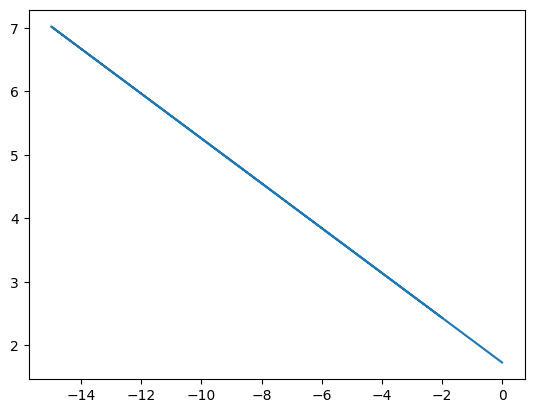

Direction is: 160.55996517182382
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -3.  -8.]
 [ -4.  -9.]
 [ -4. -10.]
 [ -5. -11.]
 [ -5. -12.]
 [ -6. -13.]
 [ -7. -14.]
 [ -7. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.93817398 -1.5643422 ]


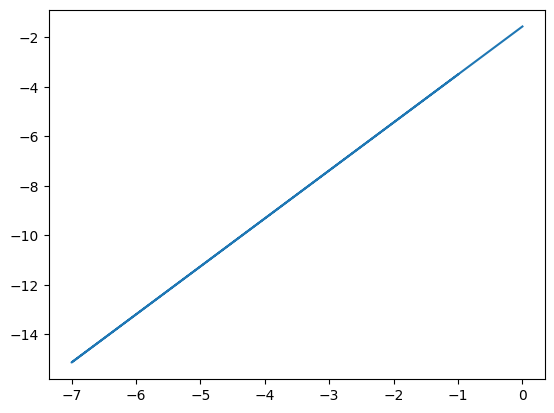

Direction is: 242.70854855258492
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 5.  7.]
 [ 6.  8.]
 [ 6.  9.]
 [ 7. 10.]
 [ 7. 11.]
 [ 8. 12.]
 [ 9. 13.]
 [ 9. 14.]
 [10. 15.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [ 1.68641115 -1.77003484]


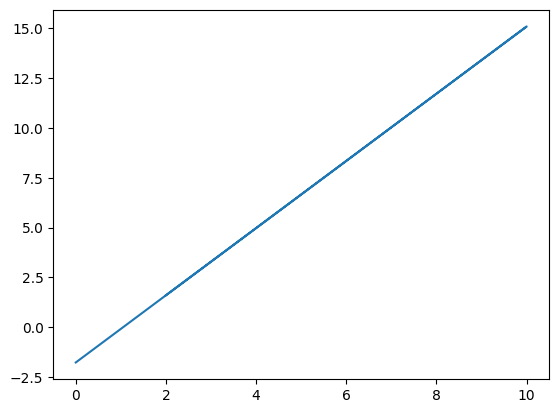

Direction is: 59.33311013525116
Sorted vector of angles: [59.33311013525116, 160.55996517182382, 242.70854855258492]


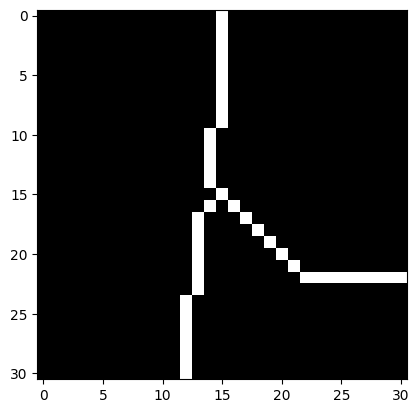

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[-1.  2.]
 [-1.  3.]
 [-1.  4.]
 [-1.  5.]
 [ 0.  6.]
 [ 0.  7.]
 [ 0.  8.]
 [ 0.  9.]
 [ 0. 10.]
 [ 0. 11.]
 [ 0. 12.]
 [ 0. 13.]
 [ 0. 14.]
 [ 0. 15.]
 [-1.  1.]
 [ 0.  0.]]
Line: [6.54545455 9.54545455]


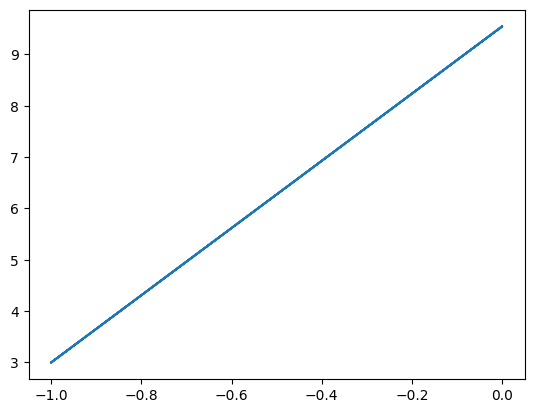

Direction is: 261.3136454187634
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -2.  -3.]
 [ -2.  -4.]
 [ -2.  -5.]
 [ -2.  -6.]
 [ -2.  -7.]
 [ -2.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -3. -11.]
 [ -3. -12.]
 [ -3. -13.]
 [ -3. -14.]
 [ -3. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [4.81818182 3.34090909]


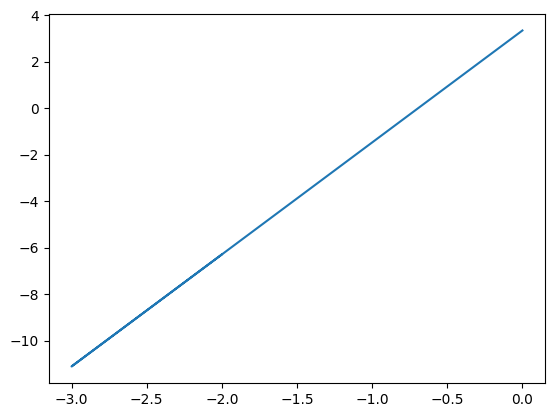

Direction is: 258.2748879848349
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -5.]
 [ 6. -6.]
 [ 7. -7.]
 [ 8. -7.]
 [ 9. -7.]
 [10. -7.]
 [11. -7.]
 [12. -7.]
 [13. -7.]
 [14. -7.]
 [15. -7.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.45294118 -1.85294118]


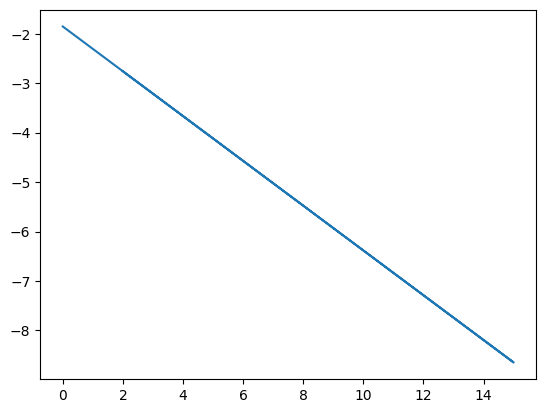

Direction is: 335.6322701584444
Sorted vector of angles: [258.2748879848349, 261.3136454187634, 335.6322701584444]
Getting intersections in skeleton (more than 2 neighbours)
0 intersections found in the skeleton
Solidity = 0.811529933481153 -> no intersection in this contour
Descriptors: [[164.30856940209483, 230.52754015165618], [59.33311013525116, 160.55996517182382, 242.70854855258492], [258.2748879848349, 261.3136454187634, 335.6322701584444]] for mapbox image 50.7684072_3.5304704.jpg
Number of descriptors: 3
Descriptor of segmentation image:
[40.36453657309736, 142.27699418746568, 262.8749836510982]
Descriptor of mapbox image:
[164.30856940209483, 230.52754015165618]
Descriptor of mapbox image:
[59.33311013525116, 160.55996517182382, 242.70854855258492]
x = 40.36453657309736, y = 59.33311013525116
x = 142.27699418746568, y = 160.55996517182382
x = 262.8749836510982, y = 242.70854855258492
Result = 33.17768701371858
Descriptor of mapbox image:
[258.2748879848349, 261.3136454187634,

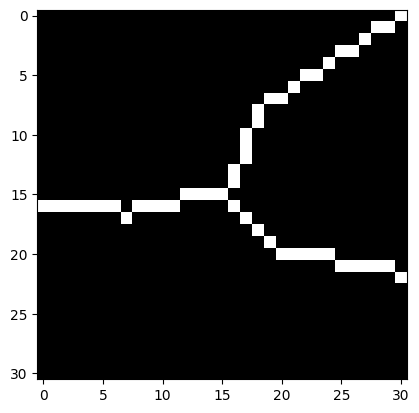

Road pixels for neighbour pixel (14, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   0.]
 [ -3.   0.]
 [ -4.  -1.]
 [ -5.  -1.]
 [ -6.  -1.]
 [ -7.  -1.]
 [ -8.  -2.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -1.]
 [-12.  -1.]
 [-13.  -1.]
 [-14.  -1.]
 [-15.  -1.]
 [ -1.   0.]
 [  0.   0.]]
Line: [ 0.07205882 -0.27205882]


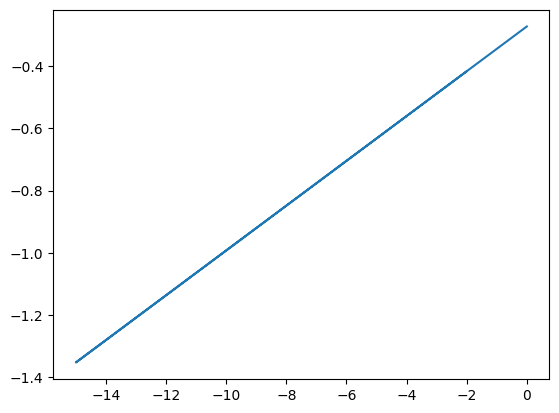

Direction is: 184.12154264809334
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 2.  3.]
 [ 2.  4.]
 [ 2.  5.]
 [ 3.  6.]
 [ 3.  7.]
 [ 4.  8.]
 [ 5.  8.]
 [ 6.  9.]
 [ 7. 10.]
 [ 8. 10.]
 [ 9. 11.]
 [10. 12.]
 [11. 12.]
 [12. 13.]
 [13. 14.]
 [14. 14.]
 [15. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.91704649 2.33090246]


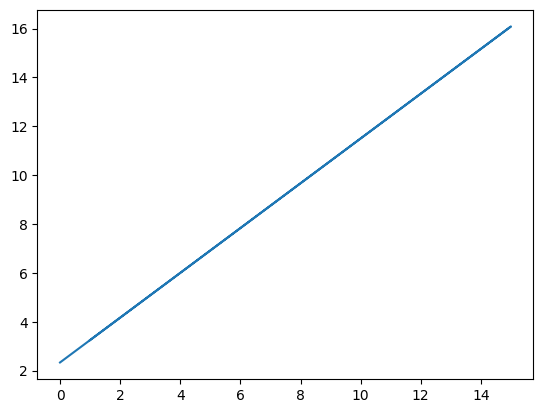

Direction is: 42.52227039180601
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -3.]
 [ 4. -4.]
 [ 5. -5.]
 [ 6. -5.]
 [ 7. -5.]
 [ 8. -5.]
 [ 9. -5.]
 [10. -6.]
 [11. -6.]
 [12. -6.]
 [13. -6.]
 [14. -6.]
 [15. -7.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.38235294 -1.63235294]


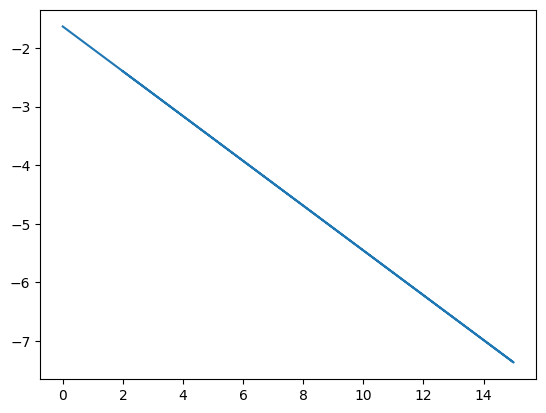

Direction is: 339.07549825507886
Sorted vector of angles: [42.52227039180601, 184.12154264809334, 339.07549825507886]
Descriptors: [[42.52227039180601, 184.12154264809334, 339.07549825507886]] for mapbox image 50.7653196_3.5320148.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[40.36453657309736, 142.27699418746568, 262.8749836510982]
Descriptor of mapbox image:
[42.52227039180601, 184.12154264809334, 339.07549825507886]
x = 40.36453657309736, y = 42.52227039180601
x = 142.27699418746568, y = 184.12154264809334
x = 262.8749836510982, y = 339.07549825507886
Result = 86.96056851825247
Descriptor of segmentation image:
[248.19859051364818, 256.1033035169851, 324.4463845785304]
Descriptor of mapbox image:
[42.52227039180601, 184.12154264809334, 339.07549825507886]
x = 248.19859051364818, y = 42.52227039180601
x = 256.1033035169851, y = 184.12154264809334
x = 324.4463845785304, y = 339.07549825507886
Result = 218.39902363245625
***********************************************

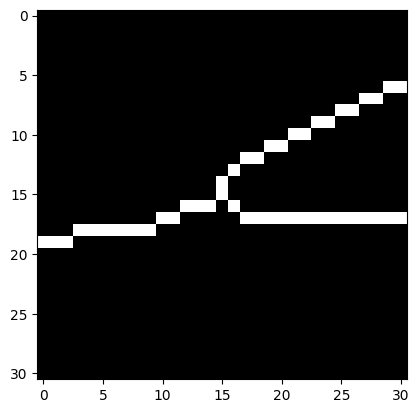

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -2.]
 [ -5.  -2.]
 [ -6.  -3.]
 [ -7.  -3.]
 [ -8.  -3.]
 [ -9.  -3.]
 [-10.  -3.]
 [-11.  -3.]
 [-12.  -3.]
 [-13.  -4.]
 [-14.  -4.]
 [-15.  -4.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.23823529 -0.71323529]


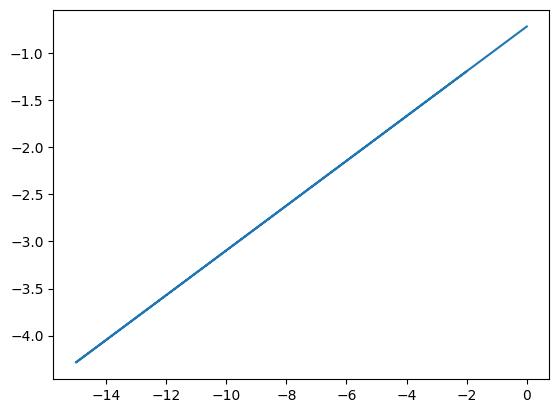

Direction is: 193.4000916277309
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 2.  3.]
 [ 3.  3.]
 [ 4.  4.]
 [ 5.  4.]
 [ 6.  5.]
 [ 7.  5.]
 [ 8.  6.]
 [ 9.  6.]
 [10.  7.]
 [11.  7.]
 [12.  8.]
 [13.  8.]
 [14.  9.]
 [15.  9.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [0.54431138 1.2754491 ]


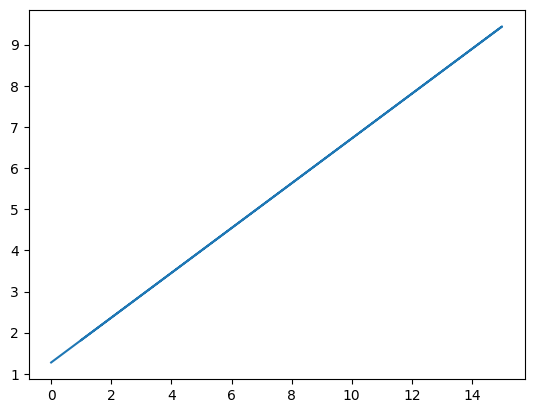

Direction is: 28.559955508050866
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -2.]
 [ 3. -2.]
 [ 4. -2.]
 [ 5. -2.]
 [ 6. -2.]
 [ 7. -2.]
 [ 8. -2.]
 [ 9. -2.]
 [10. -2.]
 [11. -2.]
 [12. -2.]
 [13. -2.]
 [14. -2.]
 [15. -2.]
 [ 1. -1.]
 [ 0.  0.]]
Line: [-0.06323529 -1.33823529]


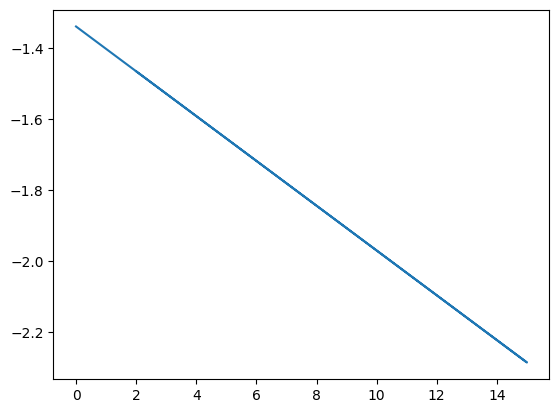

Direction is: 356.38170223086667
Sorted vector of angles: [28.559955508050866, 193.4000916277309, 356.38170223086667]


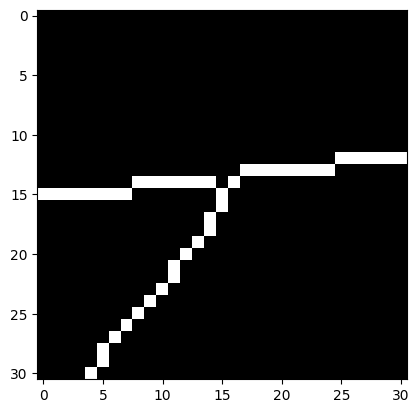

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   1.]
 [ -3.   1.]
 [ -4.   1.]
 [ -5.   1.]
 [ -6.   1.]
 [ -7.   1.]
 [ -8.   0.]
 [ -9.   0.]
 [-10.   0.]
 [-11.   0.]
 [-12.   0.]
 [-13.   0.]
 [-14.   0.]
 [-15.   0.]
 [ -1.   1.]
 [  0.   0.]]
Line: [0.07205882 0.97794118]


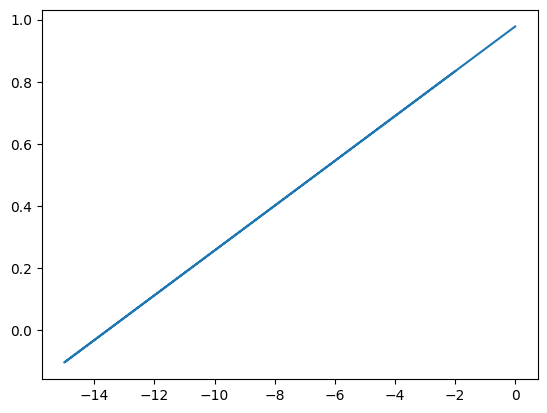

Direction is: 184.12154264809334
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -2.  -4.]
 [ -3.  -5.]
 [ -4.  -6.]
 [ -4.  -7.]
 [ -5.  -8.]
 [ -6.  -9.]
 [ -7. -10.]
 [ -8. -11.]
 [ -9. -12.]
 [-10. -13.]
 [-10. -14.]
 [-11. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 1.25623716 -1.14029938]


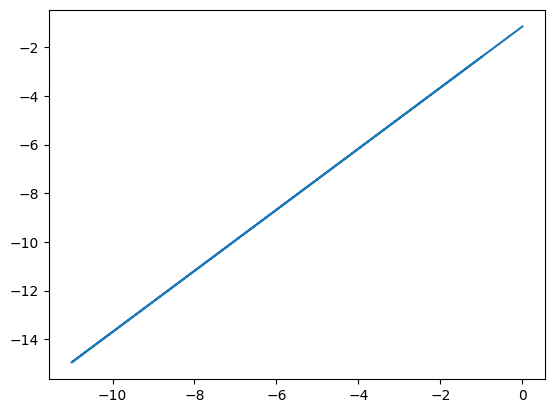

Direction is: 231.47922713757703
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  2.]
 [ 4.  2.]
 [ 5.  2.]
 [ 6.  2.]
 [ 7.  2.]
 [ 8.  2.]
 [ 9.  2.]
 [10.  3.]
 [11.  3.]
 [12.  3.]
 [13.  3.]
 [14.  3.]
 [15.  3.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.15147059 1.05147059]


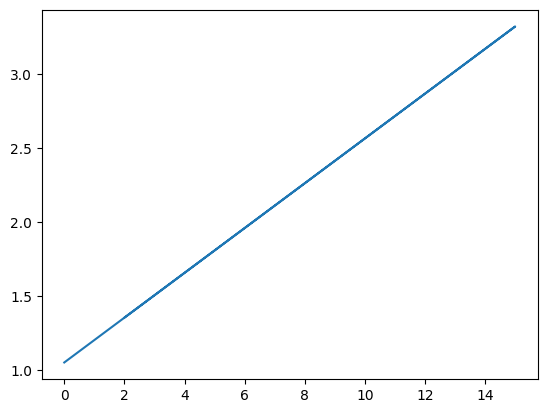

Direction is: 8.61315217983055
Sorted vector of angles: [8.61315217983055, 184.12154264809334, 231.47922713757703]


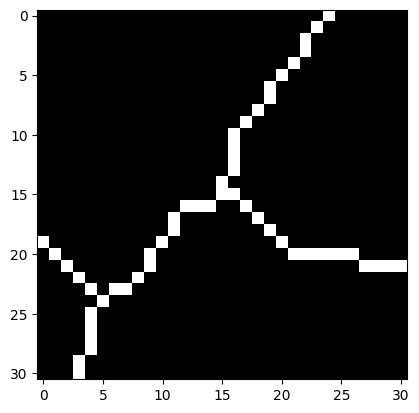

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -1.]
 [ -3.  -1.]
 [ -4.  -2.]
 [ -4.  -3.]
 [ -5.  -4.]
 [ -6.  -5.]
 [ -6.  -6.]
 [ -7.  -7.]
 [ -8.  -8.]
 [ -9.  -8.]
 [-10.  -9.]
 [-11.  -8.]
 [-12.  -7.]
 [-13.  -6.]
 [-14.  -5.]
 [-15.  -4.]
 [-11. -10.]
 [-11. -11.]
 [-11. -12.]
 [-11. -13.]
 [-12. -14.]
 [-12. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 0.69918699 -0.89837398]


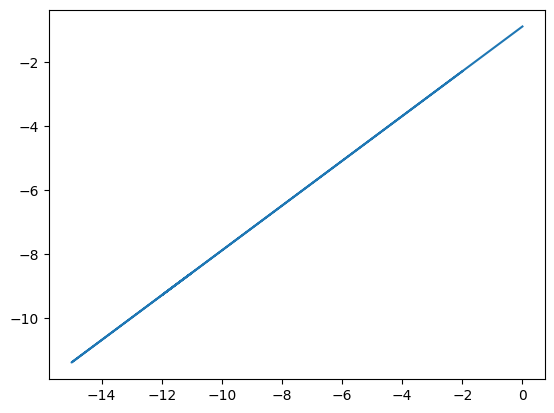

Direction is: 214.96074521284766
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 1.  2.]
 [ 1.  3.]
 [ 1.  4.]
 [ 1.  5.]
 [ 2.  6.]
 [ 3.  7.]
 [ 4.  8.]
 [ 4.  9.]
 [ 5. 10.]
 [ 6. 11.]
 [ 7. 12.]
 [ 7. 13.]
 [ 8. 14.]
 [ 9. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [1.55422243 1.7688048 ]


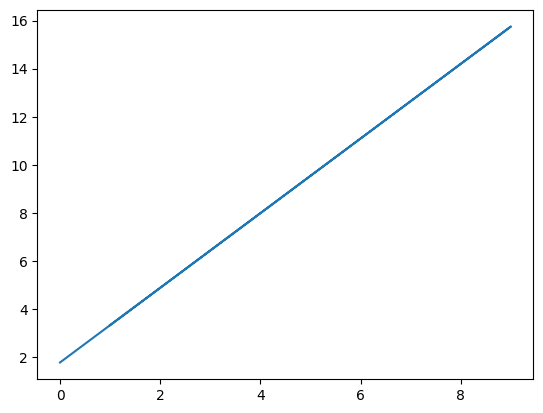

Direction is: 57.242424463894395
Road pixels for neighbour pixel (16, 15) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2. -1.]
 [ 3. -2.]
 [ 4. -3.]
 [ 5. -4.]
 [ 6. -5.]
 [ 7. -5.]
 [ 8. -5.]
 [ 9. -5.]
 [10. -5.]
 [11. -5.]
 [12. -6.]
 [13. -6.]
 [14. -6.]
 [15. -6.]
 [ 1.  0.]
 [ 0.  0.]]
Line: [-0.40882353 -0.93382353]


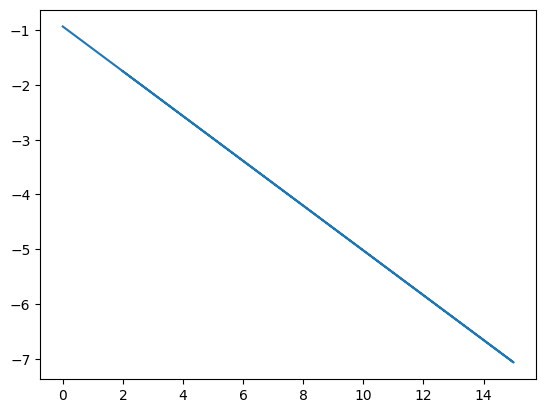

Direction is: 337.7641010200322
Sorted vector of angles: [57.242424463894395, 214.96074521284766, 337.7641010200322]


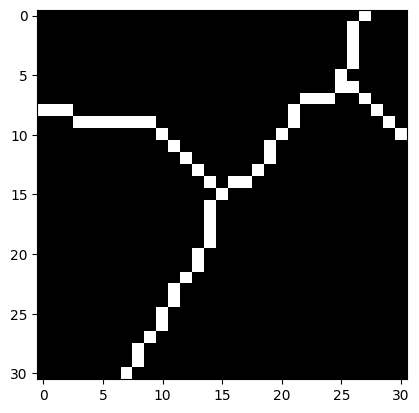

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   6.]
 [ -7.   6.]
 [ -8.   6.]
 [ -9.   6.]
 [-10.   6.]
 [-11.   6.]
 [-12.   6.]
 [-13.   7.]
 [-14.   7.]
 [-15.   7.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.41764706  1.74264706]


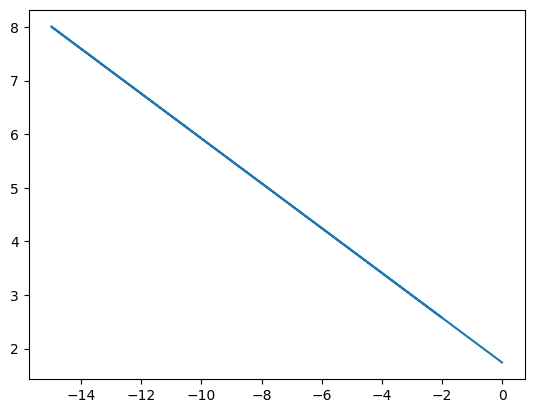

Direction is: 157.33228890064873
Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -2.  -5.]
 [ -2.  -6.]
 [ -3.  -7.]
 [ -4.  -8.]
 [ -4.  -9.]
 [ -5. -10.]
 [ -5. -11.]
 [ -6. -12.]
 [ -7. -13.]
 [ -7. -14.]
 [ -8. -15.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [ 1.83280153 -0.97064454]


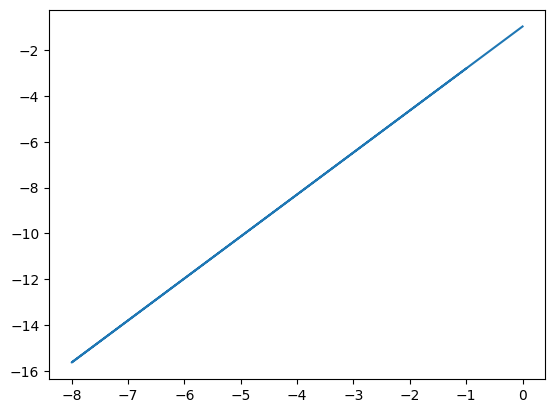

Direction is: 241.38255202120496
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  1.]
 [ 3.  2.]
 [ 4.  3.]
 [ 4.  4.]
 [ 5.  5.]
 [ 6.  6.]
 [ 6.  7.]
 [ 7.  8.]
 [ 8.  8.]
 [ 9.  8.]
 [10.  9.]
 [10. 10.]
 [11. 11.]
 [11. 12.]
 [11. 13.]
 [11. 14.]
 [12. 15.]
 [11.  9.]
 [12.  8.]
 [13.  7.]
 [14.  6.]
 [15.  5.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [0.69713831 1.47337043]


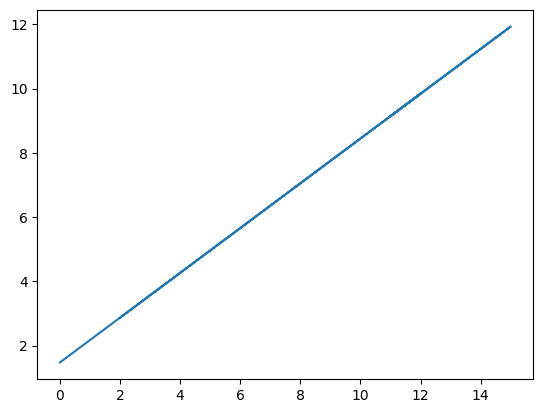

Direction is: 34.88183025681535
Sorted vector of angles: [34.88183025681535, 157.33228890064873, 241.38255202120496]


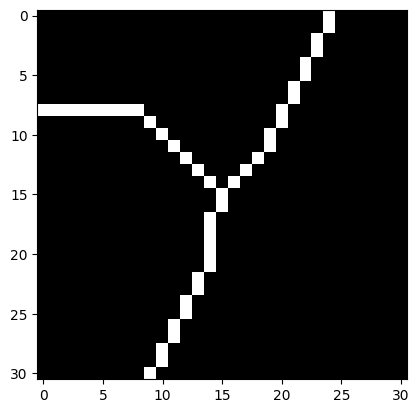

Road pixels for neighbour pixel (14, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.   2.]
 [ -3.   3.]
 [ -4.   4.]
 [ -5.   5.]
 [ -6.   6.]
 [ -7.   7.]
 [ -8.   7.]
 [ -9.   7.]
 [-10.   7.]
 [-11.   7.]
 [-12.   7.]
 [-13.   7.]
 [-14.   7.]
 [-15.   7.]
 [ -1.   1.]
 [  0.   0.]]
Line: [-0.45294118  1.85294118]


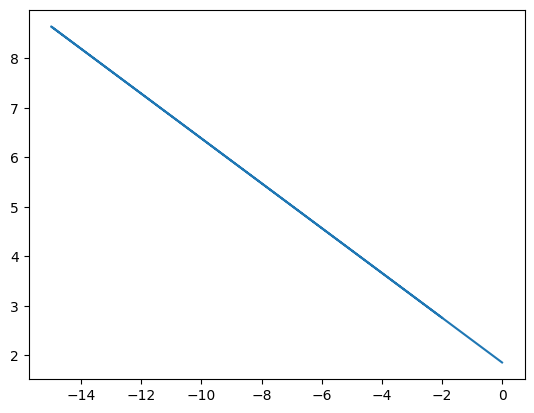

Direction is: 155.63227015844438
Road pixels for neighbour pixel (15, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -1.  -2.]
 [ -1.  -3.]
 [ -1.  -4.]
 [ -1.  -5.]
 [ -1.  -6.]
 [ -2.  -7.]
 [ -2.  -8.]
 [ -3.  -9.]
 [ -3. -10.]
 [ -4. -11.]
 [ -4. -12.]
 [ -5. -13.]
 [ -5. -14.]
 [ -6. -15.]
 [  0.  -1.]
 [  0.   0.]]
Line: [ 2.43800695 -1.55735805]


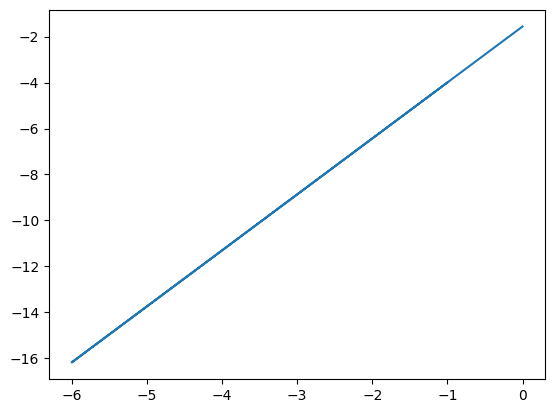

Direction is: 247.6979786893121
Road pixels for neighbour pixel (16, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 2.  2.]
 [ 3.  3.]
 [ 4.  4.]
 [ 4.  5.]
 [ 5.  6.]
 [ 5.  7.]
 [ 6.  8.]
 [ 6.  9.]
 [ 7. 10.]
 [ 7. 11.]
 [ 8. 12.]
 [ 8. 13.]
 [ 9. 14.]
 [ 9. 15.]
 [ 1.  1.]
 [ 0.  0.]]
Line: [ 1.69565217 -1.40217391]


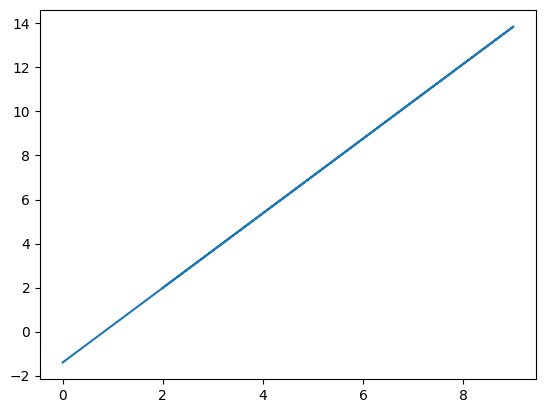

Direction is: 59.47029410006588
Sorted vector of angles: [59.47029410006588, 155.63227015844438, 247.6979786893121]
Descriptors: [[28.559955508050866, 193.4000916277309, 356.38170223086667], [8.61315217983055, 184.12154264809334, 231.47922713757703], [57.242424463894395, 214.96074521284766, 337.7641010200322], [34.88183025681535, 157.33228890064873, 241.38255202120496], [59.47029410006588, 155.63227015844438, 247.6979786893121]] for mapbox image 50.7688945_3.5296422.jpg
Number of descriptors: 5
Descriptor of segmentation image:
[40.36453657309736, 142.27699418746568, 262.8749836510982]
Descriptor of mapbox image:
[28.559955508050866, 193.4000916277309, 356.38170223086667]
x = 40.36453657309736, y = 28.559955508050866
x = 142.27699418746568, y = 193.4000916277309
x = 262.8749836510982, y = 356.38170223086667
Result = 107.22138613897938
Descriptor of mapbox image:
[8.61315217983055, 184.12154264809334, 231.47922713757703]
x = 40.36453657309736, y = 8.61315217983055
x = 142.27699418746568

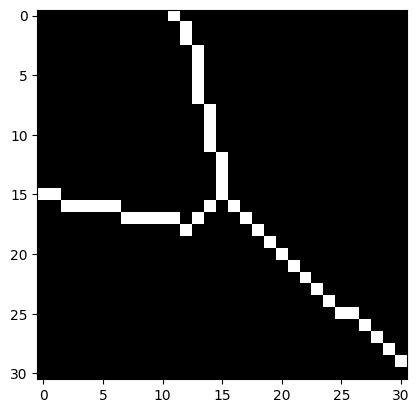

Road pixels for neighbour pixel (14, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ -2.  -2.]
 [ -3.  -3.]
 [ -4.  -2.]
 [ -5.  -2.]
 [ -6.  -2.]
 [ -7.  -2.]
 [ -8.  -2.]
 [ -9.  -1.]
 [-10.  -1.]
 [-11.  -1.]
 [-12.  -1.]
 [-13.  -1.]
 [-14.   0.]
 [-15.   0.]
 [ -1.  -1.]
 [  0.   0.]]
Line: [-0.08382353 -1.94117647]


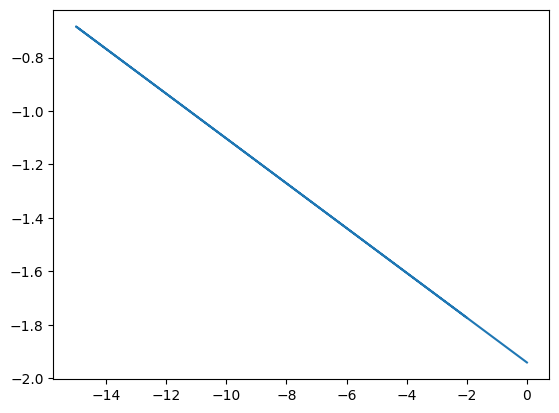

Direction is: 175.2084669742429
Road pixels for neighbour pixel (15, 14) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[ 0.  2.]
 [ 0.  3.]
 [-1.  4.]
 [-1.  5.]
 [-1.  6.]
 [-1.  7.]
 [-2.  8.]
 [-2.  9.]
 [-2. 10.]
 [-2. 11.]
 [-2. 12.]
 [-3. 13.]
 [-3. 14.]
 [-4. 15.]
 [ 0.  1.]
 [ 0.  0.]]
Line: [-3.77272727  1.84090909]


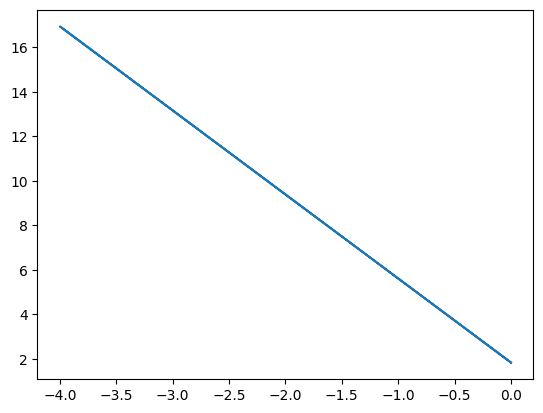

Direction is: 104.84545208208382
Road pixels for neighbour pixel (16, 16) (including intersection): 
Road pixels after adjustment (intersection is now origin): 
[[  2.  -2.]
 [  3.  -3.]
 [  4.  -4.]
 [  5.  -5.]
 [  6.  -6.]
 [  7.  -7.]
 [  8.  -8.]
 [  9.  -9.]
 [ 10. -10.]
 [ 11. -10.]
 [ 12. -11.]
 [ 13. -12.]
 [ 14. -13.]
 [ 15. -14.]
 [  1.  -1.]
 [  0.   0.]]
Line: [-0.91911765 -0.29411765]


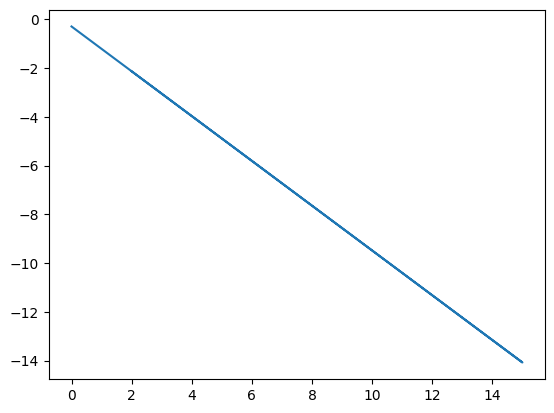

Direction is: 317.4133364328499
Sorted vector of angles: [104.84545208208382, 175.2084669742429, 317.4133364328499]
Descriptors: [[104.84545208208382, 175.2084669742429, 317.4133364328499]] for mapbox image 50.7645454_3.5376782.jpg
Number of descriptors: 1
Descriptor of segmentation image:
[40.36453657309736, 142.27699418746568, 262.8749836510982]
Descriptor of mapbox image:
[104.84545208208382, 175.2084669742429, 317.4133364328499]
x = 40.36453657309736, y = 104.84545208208382
x = 142.27699418746568, y = 175.2084669742429
x = 262.8749836510982, y = 317.4133364328499
Result = 90.6460274304953
Descriptor of segmentation image:
[248.19859051364818, 256.1033035169851, 324.4463845785304]
Descriptor of mapbox image:
[104.84545208208382, 175.2084669742429, 317.4133364328499]
x = 248.19859051364818, y = 104.84545208208382
x = 256.1033035169851, y = 175.2084669742429
x = 324.4463845785304, y = 317.4133364328499
Result = 164.75302923975536
**************************************************
Mapb

In [20]:
best_mb_image = None
lowest_score = 1000

for mb_image in os.listdir(mapbox_imgs_dir_path) : 
    best_results = []
    score = 1000
    mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)
    print(50*"*")
    print(f"Mapbox image: {mb_image}")
    print(50*"*")
    mb_image_bgr = cv2.imread(mb_image_path)
    plot_image(mb_image_bgr)
    des = find_descriptors_in_mapbox_image(mb_image_path, mb_image)
    print(f"Descriptors: {des} for mapbox image {mb_image}")

    # matching process
    if des is not None and segm_img_des is not None :
        print(f"Number of descriptors: {len(des)}")
        for des_segm in segm_img_des :
            best_result_per_des = 1000 # best descriptor match for descriptor des_segm of segmentation image
            print(f"Descriptor of segmentation image:")
            print(des_segm)
            for des_ in des :
                print(f"Descriptor of mapbox image:")
                print(des_)

                if len(des_segm) == len(des_) : 
                    result = 0
                    for x, y in zip(des_segm, des_) :
                        print(f"x = {x}, y = {y}")
                        result += (x-y)**2
                    result = math.sqrt(result)
                elif len(des_) > len(des_segm) :
                    for x in des_segm : 
                        best_diff = 1000
                        for y in des_ :
                            diff = abs(x-y)
                            if diff < best_diff :
                                best_diff = diff
                        result += best_diff**2
                    result = math.sqrt(result)
                else :
                    # this can't be the case 
                    continue

                print(f"Result = {result}")
            
                if result < best_result_per_des :
                    best_result_per_des = result

            best_results.append(best_result_per_des)
        
        score = np.sum(best_results)
        
        # make sure there is at least one best result that is below the threshold 
        threshold = 40
        if score < lowest_score and any(result < threshold for result in best_results) :
            lowest_score = score
            best_mb_image = mb_image
    else:
        continue

print(f"Lowest score = {lowest_score} with mapbox image {best_mb_image}")